# Article **Skimmer** and **Summarizer** with Neural Networks

## Abstract

![image](Documents/rnn-seq.png)

This is a `many to one` sequence problem! <br>
**Why?**  because it involves processing a sequence of input data (e.g., words or sentences in an article) and producing a single output (e.g., a summary or classification):<br>
1. **Sequence as Input (Many):**
The article skimmer takes a sequence of words or sentences, each represented as a unit of input (e.g., word embeddings or sentence embeddings). This sequence may vary in length depending on the article.
2. **Single Output (One):**
The skimmer's goal is to generate one outcome, such as:
A summarized version of the article.
A classification label (e.g., "sports" or "technology").
A specific metric or decision (e.g., "relevant" or "irrelevant").

![image](Documents/The-standard-RNN.png)

In many natural language processing (NLP) tasks, understanding the context requires processing the entire sequence to identify key ideas, themes, or categories. This aligns with models like recurrent neural networks (RNNs), transformers, or similar architectures, which can process sequences to produce a unified output.

##### What is a sequence in RNN?

A recurrent neural network (RNN) is a deep learning model that is trained to process and convert a sequential data input into a specific sequential data output. Sequential data is data—such as words, sentences, or time-series data—where sequential components interrelate based on complex semantics and syntax rules.

##### Why RNNs are suitable for sequence problems?

RNN maintains internal memory, due to this they are very efficient for machine learning problems that involve sequential data. RNNs are also used in time series predictions as well.

## Dataset

We are using a commonly used dataset by **Franck Dernoncourt, Ji Young Lee**.<br>
<a href="https://arxiv.org/abs/1710.06071">PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts</a><br>
The dataset consists of approximately 200,000 abstracts of randomized controlled trials, totaling 2.3 million sentences. Each sentence of each abstract is labeled with their role in the abstract using one of the following classes: background, objective, method, result, or conclusion. 

## Coding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
import os

In [2]:
path_of_data = "Dataset/PubMed_20k_RCT_numbers_replaced_with_at_sign"
filenames = [path_of_data + "/" + filename + ".txt" for filename in ["train","test","dev"] ]
filenames

['Dataset/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'Dataset/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'Dataset/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [3]:
def preprocess_txt_lines(filename, num_lines=10):
    with open(filename, "r") as file:
        for i, line in enumerate(file):
            if not line.strip():
                continue
            target = line.strip().split()[0]
            print(f"\033[1m{target}\033[0m", " ".join(line.strip().split()[1:]))
            print()
            if i + 1 >= num_lines:
                break

preprocess_txt_lines(filenames[0])

###24293578 

OBJECTIVE To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .

METHODS A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .

METHODS Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .

METHODS Pain was assessed using the visual analog pain scale ( @-@ mm ) .

METHODS Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .

METHODS Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein (

## A data structure to organize it!

Let's improve `preprocess_txt_lines` <br>
We use a list of dictionaries:<br>
[{<br> **line_number:** 0<br>, **target:** "METHODS"<br> , **text:** "Further , there was a clinically relevant reduction in the serum levels"<br> , **total_lines:** 11 <br>}]

In [4]:
def preprocess_txt_lines(filename):
    with open(filename, "r") as file:
        processed_lines = []  # Flat list to store all dictionaries
        section_start_idx = 0
        i = 1
        for line in file:
            if line.startswith("###"):
                if section_start_idx < len(processed_lines):
                    section_line_count = i - 2
                    for j in range(section_start_idx, len(processed_lines)):
                        processed_lines[j]["line_count"] = section_line_count
                section_start_idx = len(processed_lines)
                i = 1
                continue
            if not line.strip():
                continue
            line_number = i
            words = line.strip().split()
            target = words[0] if words else ""
            text = " ".join(words[1:])
            processed_lines.append({"line_number": line_number, "target": target, "text": text})
            i += 1
        if section_start_idx < len(processed_lines):
            section_line_count = i - 2
            for j in range(section_start_idx, len(processed_lines)):
                processed_lines[j]["line_count"] = section_line_count
        return processed_lines


In [5]:
%%time 
train_samples = preprocess_txt_lines(filenames[0])
test_samples = preprocess_txt_lines(filenames[1])
val_samples = preprocess_txt_lines(filenames[2])

CPU times: total: 78.1 ms
Wall time: 742 ms


In [6]:
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)

In [7]:
train_df[:30]

,line_number,target,text,line_count
0,1,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,2,METHODS,A total of @ patients with primary knee OA wer...,11
2,3,METHODS,Outcome measures included pain reduction and i...,11
3,4,METHODS,Pain was assessed using the visual analog pain...,11
4,5,METHODS,Secondary outcome measures included the Wester...,11
5,6,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",11
6,7,RESULTS,There was a clinically relevant reduction in t...,11
7,8,RESULTS,The mean difference between treatment arms ( @...,11
8,9,RESULTS,"Further , there was a clinically relevant redu...",11
9,10,RESULTS,These differences remained significant at @ we...,11


In [8]:
test_df

,line_number,target,text,line_count
0,1,BACKGROUND,This study analyzed liver function abnormaliti...,8
1,2,RESULTS,A post hoc analysis was conducted with the use...,8
2,3,RESULTS,Liver function tests ( LFTs ) were measured at...,8
3,4,RESULTS,Survival analyses were used to assess the asso...,8
4,5,RESULTS,The percentage of patients with abnormal LFTs ...,8
...,...,...,...,...
30130,14,RESULTS,There was a statistically significant between-...,17
30131,15,RESULTS,There were no statistically significant betwee...,17
30132,16,RESULTS,There was no significant association between s...,17
30133,17,RESULTS,No adverse effects were reported .,17


In [9]:
val_df

,line_number,target,text,line_count
0,1,BACKGROUND,IgE sensitization to Aspergillus fumigatus and...,9
1,2,BACKGROUND,It is not clear whether these patients would b...,9
2,3,OBJECTIVE,We sought to determine whether a @-month cours...,9
3,4,METHODS,Asthmatic patients who were IgE sensitized to ...,9
4,5,METHODS,Primary outcomes were improvement in quality o...,9
...,...,...,...,...
30207,10,RESULTS,Pruritus occurred more frequently with the act...,13
30208,11,RESULTS,Three patients in the active-regimen group ( @...,13
30209,12,RESULTS,Hemoglobin values of grade @ ( @ to < @ g per ...,13
30210,13,CONCLUSIONS,Rates of response to a @-week interferon-free ...,13


In [10]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

11.789135747611642


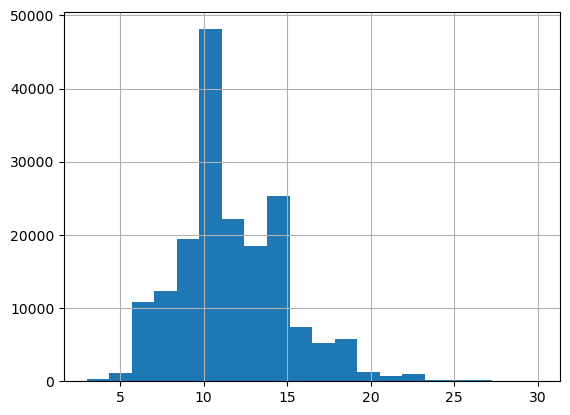

In [11]:
train_df.line_count.hist(bins=20)
print(train_df.line_count.mean())

In [12]:
train_x = train_df["text"].to_numpy()
train_y = train_df["target"].to_numpy()

test_x = test_df["text"].to_numpy()
test_y = test_df["target"].to_numpy()

val_x = val_df["text"].to_numpy()
val_y = val_df["target"].to_numpy()

## One Hot encoding(Baseline)

In [13]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)
train_ohe = ohe.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_ohe = ohe.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_ohe = ohe.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

train_ohe

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encoding(ANN)

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_le = le.fit_transform(train_df["target"].to_numpy())
val_le = le.fit_transform(val_df["target"].to_numpy())
test_le = le.fit_transform(test_df["target"].to_numpy())

print(train_le)
print(dict(zip(le.classes_, le.transform(le.classes_))))

[3 2 2 ... 4 1 1]
{'BACKGROUND': 0, 'CONCLUSIONS': 1, 'METHODS': 2, 'OBJECTIVE': 3, 'RESULTS': 4}


## Baseline model(Machine learning naive bayes)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0 = Pipeline([("tokenizing",TfidfVectorizer()),("Naive",MultinomialNB())])

model_0.fit(X=train_x,y=train_le)
model_0.score(X=val_x,y=val_le)

0.7218323844829869

In [16]:
train_df.iloc[12]

line_number                                                    1
target                                                BACKGROUND
text           Emotional eating is associated with overeating...
line_count                                                    10
Name: 12, dtype: object

In [17]:
model_0.predict([train_x[12]])

array([0])

## Conv1D with token embedding

1. See how long is each sentence on average?

In [18]:
train_x[0]

'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .'

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


26.338269273494777 55.0


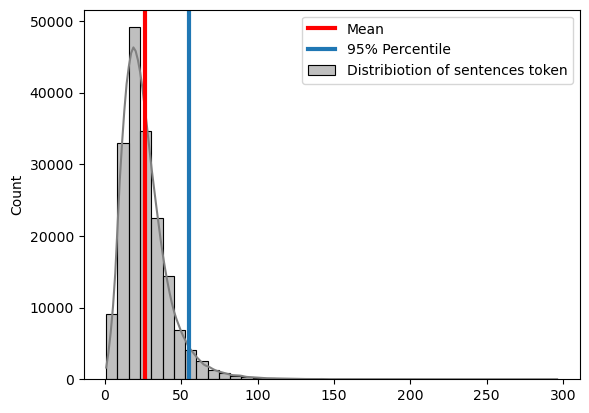

In [19]:
sent_lens = [len(sentence.split()) for sentence in train_x]
mean_sent_lens = np.mean(sent_lens)
sns.histplot(sent_lens,bins=40,kde=True,color="gray",label="Distribiotion of sentences token")
print(mean_sent_lens,np.percentile(sent_lens,q=95))
plt.axvline(mean_sent_lens,color="red",label="Mean",linewidth=3)
plt.axvline(np.percentile(sent_lens,q=95),label="95% Percentile",linewidth=3)
plt.legend()

MaxVocab = 10000
MaxSentenceTokens = 55

## Tokenazation

In [20]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding

text_vector = TextVectorization(output_sequence_length= MaxSentenceTokens, max_tokens = MaxVocab)
text_vector.adapt(train_x)
print(train_x[2]," == ",text_vector([train_x[2]]))
print("Vocabulary Size: ",text_vector.vocabulary_size())
print("Top 10 most repeated: ",text_vector.get_vocabulary()[:10])
print("Bottom 10 least repeated: ",text_vector.get_vocabulary()[-10:])

Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .  ==  tf.Tensor(
[[ 86 213 121  65 169   3 194   5 149 119   3 670 636 747   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]], shape=(1, 55), dtype=int64)
Vocabulary Size:  10000
Top 10 most repeated:  ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
Bottom 10 least repeated:  ['expanding', 'exhibiting', 'exercisebased', 'evaluators', 'evacuation', 'ethnically', 'ethambutol', 'ert', 'epicardial', 'ephedrine']


## Embedding

In [27]:
from tensorflow.keras.layers import Embedding

embedding_vector = Embedding(input_dim=MaxVocab,output_dim=128)
embedded_sample = embedding_vector(text_vector(np.array([train_x[22]])))
embedded_sample

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[-0.01631999,  0.031984  ,  0.00476489, ...,  0.01044031,
          0.04080457,  0.00599877],
        [-0.03964945,  0.03390511,  0.04499412, ...,  0.00855775,
          0.03153724, -0.03121504],
        [ 0.01202201, -0.04972878,  0.03305184, ...,  0.04795431,
          0.04253311, -0.0132736 ],
        ...,
        [ 0.04731264, -0.03470482,  0.03236574, ...,  0.00857327,
         -0.04024804, -0.01978463],
        [ 0.04731264, -0.03470482,  0.03236574, ...,  0.00857327,
         -0.04024804, -0.01978463],
        [ 0.04731264, -0.03470482,  0.03236574, ...,  0.00857327,
         -0.04024804, -0.01978463]]], dtype=float32)>

In [31]:
model_1 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype="string"),  # Specify dtype as "string"
    text_vector,
    embedding_vector,
    layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu"),
    layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu"),
    layers.GlobalAvgPool1D(),
    layers.Dense(64, activation="relu"),
    layers.Dense(5, activation="softmax")  # Final output layer
])
model_1.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy, metrics=['accuracy'])
model_1.summary()
history = model_1.fit(train_x, train_ohe, epochs=5, batch_size=32,
                     validation_data=(val_x,val_ohe))

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 55, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 51, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 47, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,346,053 (5.13 MB)

 Trainable params: 1,346,053 (5.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 109s 19ms/step - accuracy: 0.6927 - loss: 0.2627 - val_accuracy: 0.8180 - val_loss: 0.1780
Epoch 2/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 112s 20ms/step - accuracy: 0.8340 - loss: 0.1656 - val_accuracy: 0.8239 - val_loss: 0.1714
Epoch 3/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 113s 20ms/step - accuracy: 0.8606 - loss: 0.1417 - val_accuracy: 0.8197 - val_loss: 0.1784
Epoch 4/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 140s 20ms/step - accuracy: 0.8843 - loss: 0.1213 - val_accuracy: 0.8191 - val_loss: 0.1867
Epoch 5/5
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 116s 21ms/step - accuracy: 0.9051 - loss: 0.1019 - val_accuracy: 0.8063 - val_loss: 0.2003


In [45]:
for i in range(10):
    input_data = np.array([str(val_x[i])])  # Ensure string type
    prediction = model_1.predict(input_data)
    print(test_x[i], "| Actual = ", test_y[i], "| Predicted = ", prediction)
    print()


ValueError: Invalid dtype: str4288

In [38]:
test_x[0]

'This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .'